Jesus is a Rasin

In [1]:
import cupy
from cupy import fft
import tifffile
import math
import numpy as np
import ComputeGaussianPSF as CG

import matplotlib.pyplot as plt

from pypher.pypher import (parse_args, format_kernel_header,
                           imrotate, imresample, trim, zero_pad,
                           psf2otf, homogenization_kernel)
import RL_TV


Loading all the Shazbot

In [2]:
stack_filename = '/home/imaging/Documents/MATLAB/Matlab Magic/Extended-Volume-3D-deconvolution-master/Extended-Volume-3D-deconvolution-master/code/aligned_vol_crop2.tif'
#stack_filename = r'G:\My Drive\MATLAB\Extended-Volume-3D-deconvolution-master\Extended-Volume-3D-deconvolution-master\code\aligned_vol_crop2.tif'
stack = tifffile.imread(stack_filename)

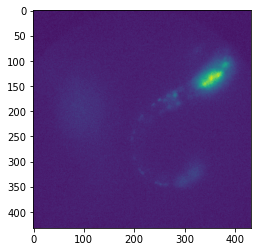

In [3]:
plt.imshow(stack[273,13,:,: ])                                                                                                                                                                                                                                                                                                                                                                                             

In [4]:

# matlab code
# [XX,YY,ZZ,TT] = size(stack); <--- needs to be [TT,ZZ,YY,XX]

dims = stack.shape
XX = dims[3]
YY = dims[2]
ZZ = dims[1]
TT = dims[0]

# %imaging parameters (Original)
# % NA = 0.4; % objective numerical aperture
# % dz = 20.56; % delta z, um
# % dx = 1.083; % laterial pixel size, um
# % lambda = 0.51; % wavelength, um
# % index = 1.0; % refractive index

# %OURS M25
# % imaging parameters
NumAp = 1.4 # objective numerical aperture
dz = 2.0 # % delta z, um
dx = 0.380 # % laterial pixel size, um
waveLength = 0.515 # % wavelength, um
index = 1.51 # % refractive index

# optimization parameters
TV_reg = 0.0005 # amount of TV regularization
xy_pad = 50 # lateral volume extension
z_pad = 8 # axial volume extension
# Original settings
# outer_iter = 20 # number of outer iterations of EV-3D
# inner_iter = 80 # number of inner iterations of EV-3D

# rl_iter = 200 # number of iteratins for traditional RL-3D
outer_iter = 5 # number of outer iterations of EV-3D
inner_iter = 20 # number of inner iterations of EV-3D

rl_iter = 200 # number of iteratins for traditional RL-3D

The thing it does

41
(41,)
xi shape: (41,)
L: 202.16 dx: 0.38 Nx: 532
complex64
(41, 532, 532)
[[0.01980263+0.01228031j 0.01964321+0.01234265j 0.01948674+0.01240544j
  ... 0.01581873+0.01405269j 0.01568796+0.01410315j
  0.01555692+0.01415235j]
 [0.01964321+0.01234265j 0.01948844+0.01240652j 0.01933627+0.01247072j
  ... 0.01570714+0.01412039j 0.01557652+0.01417018j
  0.01544561+0.01421868j]
 [0.01948674+0.01240544j 0.01933627+0.01247072j 0.01918808+0.0125362j
  ... 0.01559486+0.01418686j 0.01546438+0.01423597j
  0.01533359+0.01428377j]
 ...
 [0.01581873+0.01405269j 0.01570714+0.01412039j 0.01559486+0.01418686j
  ... 0.0123448 +0.01547989j 0.01221804+0.01550793j
  0.01209097+0.01553448j]
 [0.01568796+0.01410315j 0.01557652+0.01417018j 0.01546438+0.01423597j
  ... 0.01221804+0.01550793j 0.01209149+0.01553515j
  0.01196464+0.01556089j]
 [0.01555692+0.01415235j 0.01544561+0.01421868j 0.01533359+0.01428377j
  ... 0.01209097+0.01553448j 0.01196464+0.01556089j
  0.01183802+0.01558581j]]


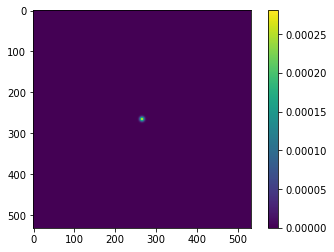

In [15]:
## EV-3D deconvolution
Nx = XX + 2*xy_pad
Ny = YY + 2*xy_pad ## image should be square so XX == YY
Nz = ZZ + 2*z_pad

# psf = ComputeGaussianPSF(NA,lambda,dx,dz,Nx,floor(Nz/2),index);
psf = CG.ComputeGaussianPSF(NumAp,waveLength,dx,dz,Nx,math.floor(Nz/2),index)

''' The Pypher psf2otf libray used np.fft.fft2 instead of fftn
    And does not match the matlab output for that reason   '''
    
otf = np.complex64(psf2otf(psf, psf.shape))
#otf = np.reshape(otf, (otf.size,), order='C')
# print(psf.dtype)
# print(psf.shape)
# print(psf[0 ,47:79, 47:79])
print(otf.dtype)
print(otf.shape)
print(otf[0 ,47:79, 47:79])
plt.imshow(psf[19,:,:])
plt.colorbar()
# print(type(psf[0,0,0]))
# print(type(otf[12,215,215]))
# print(otf[12,215,215])
#plt.imshow(np.abs(otf[0,:,:]))

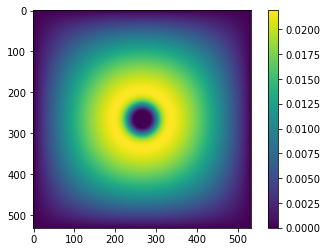

In [16]:
plt.imshow(np.abs(np.fft.fftshift(otf[19,:,:])))
plt.colorbar()

In [20]:
#im_ev = padarray(stack, [xy_pad, xy_pad, z_pad], 'replicate', 'both'); % image over V_EV
#im_mask = padarray(stack, [xy_pad, xy_pad, z_pad], 0, 'both');
#im_mask = find(im_mask>0); % pixel indices of V_I
#obs = stack(stack>0); % corresponding pixel values of V_I
im_ev = np.pad(stack[300,:,:,:], ((z_pad,),(xy_pad,), (xy_pad,)), 'edge' )
im_ev = im_ev.astype(np.float32)
#im_ev = np.reshape(im_ev, (im_ev.size,), order='C')
im_mask = np.pad(stack[300,:,:,:], ((z_pad,), (xy_pad,), (xy_pad,)), 'constant', constant_values=(0,) )
print(im_mask.shape)
im_mask = np.ravel_multi_index(np.where(im_mask>0),im_mask.shape)
#im_mask = np.where(im_mask>0); # pixel indices of V_I
temp = stack[300,:,:,:].astype(np.float32)
obs = temp[np.where(temp != 0)] # corresponding pixel values of V_I
#print(im_mask)
print(obs.size)
print(stack[300,0,0,0])

(41, 532, 532)
4665600
848


695063552
2051882496
1
2384199680
(4665600,)
(41, 532, 532)
(41, 532, 532)
(4665600,)
32539168
73
<class 'numpy.float32'>
float64
(41, 532, 532)
2388393984
(41, 532, 532)


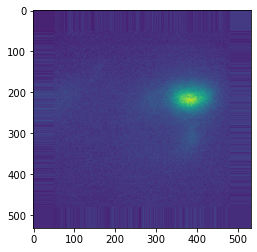

In [21]:
plt.figure(1)
plt.imshow(np.reshape(im_ev, (Nz, Nx, Ny), order='C')[7,:,:])
mempool = cupy.get_default_memory_pool()
pinned_mempool = cupy.get_default_pinned_memory_pool()
print(mempool.used_bytes())
print(mempool.total_bytes())
print(pinned_mempool.n_free_blocks())
dev0 = cupy.cuda.Device(0)


print(dev0.mem_info[0])

size_of_files = obs.size + im_ev.size + otf.size + im_mask.size
print(obs.shape)
print(im_ev.shape)
print(otf.shape)
print(im_mask.shape)
print(size_of_files)
print(math.floor(dev0.mem_info[0]/size_of_files))
obs_cp = cupy.asarray(obs)
im_ev_cp = cupy.asarray(im_ev)
otf_cp = cupy.asarray(otf)
im_mask_cp = cupy.asarray(im_mask)
est = cupy.asarray(cupy.zeros((Nz,Ny,Nx),dtype=cupy.float64), order='C')
print(type(im_ev[0,0,0]))
print(est.dtype)
print(est.shape)
print(dev0.mem_info[0])
print(im_ev_cp.shape)


# plt.figure(2)
# plt.imshow(im_mask[:,:,:])


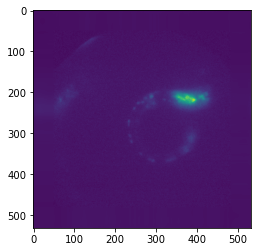

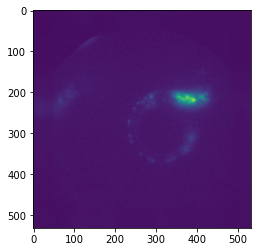

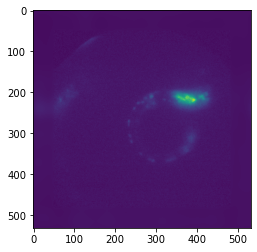

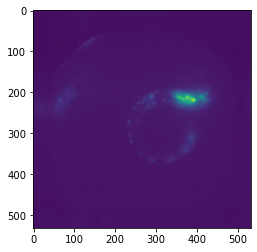

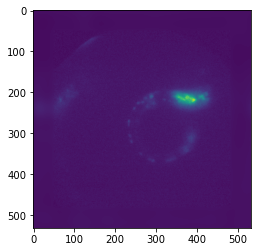

In [22]:
import RL_TV
for i in range(outer_iter):
    with cupy.cuda.Device(0):
        est = RL_TV.RL_TV(im_ev_cp, otf_cp, inner_iter, TV_reg, Nz, Ny, Nx).astype(cupy.float32)
        im_ev_cp = cupy.real(cupy.fft.ifftn(cupy.fft.fftn(est)*otf_cp)).astype(cupy.float32)
        im_ev_cp = cupy.maximum(im_ev_cp, 0) # maximum function =/= max function
        cupy.reshape(im_ev_cp, (im_ev_cp.size,), order='C')[im_mask_cp] = obs_cp
        plt.figure(i)
        plt.imshow(est[19,:,:].get())
 


In [10]:
print(type(im_ev_cp[19, 250, 250]))
print(type(im_ev_cp.dtype))
print(type(est.dtype))
print(type(otf_cp.dtype))

<class 'cupy._core.core.ndarray'>
<class 'numpy.dtype[float32]'>
<class 'numpy.dtype[float64]'>
<class 'numpy.dtype[complex64]'>


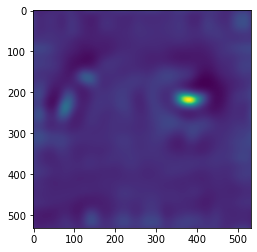

In [11]:
plt.imshow(np.reshape(est, (Nz, Ny, Nx), order='C')[0,:,:].get())

In [12]:
est

array([[[ 997.69891357,  991.8460083 ,  973.58087158, ...,
         1039.13842773, 1032.03540039, 1030.07702637],
        [1002.96142578,  996.70007324,  977.9967041 , ...,
         1045.73742676, 1038.18786621, 1036.05310059],
        [1015.61004639, 1008.67657471,  989.18432617, ...,
         1060.63720703, 1052.35461426, 1049.92468262],
        ...,
        [ 964.71832275,  960.33605957,  943.83642578, ...,
         1001.23614502,  995.68945312,  994.30828857],
        [ 966.67608643,  961.86993408,  944.71484375, ...,
         1003.77722168,  997.42816162,  997.75799561],
        [ 967.32305908,  962.08898926,  944.94274902, ...,
         1006.99688721, 1000.99841309,  997.39813232]],

       [[ 968.90625   ,  960.59082031,  940.19677734, ...,
         1017.19238281, 1007.41503906, 1004.27722168],
        [ 973.51873779,  964.60949707,  943.59356689, ...,
         1023.79901123, 1013.29766846, 1009.8371582 ],
        [ 985.09942627,  975.18408203,  953.06402588, ...,
         1038.

226129.0


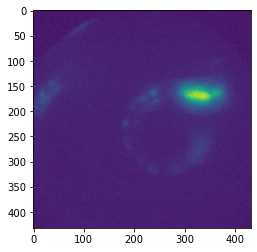

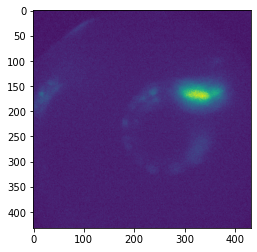

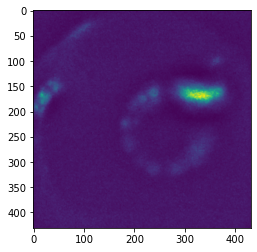

In [13]:
plt.imshow(np.real(np.reshape(im_ev_cp, (Nz, Ny, Nx), order = 'C')[21,49:481,49:481].get()))
plt.figure(2)
plt.imshow(stack[300,13,:,:])
EVdeconv = np.reshape(est, (Nz, Ny, Nx), order='C')[(z_pad+1):(z_pad+ZZ),(xy_pad+1):(xy_pad+XX), (xy_pad+1):(xy_pad+YY)] #% deconvolution results
maxEV = np.max(np.real(EVdeconv[:]))
print(maxEV)
EVdeconv = (np.real(EVdeconv)/maxEV) * (2^16 - 1)
plt.figure(3)
plt.imshow(np.real(EVdeconv[13,:,:].get()))

In [14]:
import pandas as pd
print(psf.shape)
print(psf)

#plibt = np.uint16((psf/np.max(psf))*(2**16 - 1))
#print(plibt.shape)
tifffile.imwrite("psfdouble.tif", psf)

(41, 532, 532)
[[[1.64456700e-12 1.72682715e-12 1.81286797e-12 ... 1.81286797e-12
   1.72682715e-12 1.64456700e-12]
  [1.72682715e-12 1.81320190e-12 1.90354642e-12 ... 1.90354642e-12
   1.81320190e-12 1.72682715e-12]
  [1.81286797e-12 1.90354642e-12 1.99839245e-12 ... 1.99839245e-12
   1.90354642e-12 1.81286797e-12]
  ...
  [1.81286797e-12 1.90354642e-12 1.99839245e-12 ... 1.99839245e-12
   1.90354642e-12 1.81286797e-12]
  [1.72682715e-12 1.81320190e-12 1.90354642e-12 ... 1.90354642e-12
   1.81320190e-12 1.72682715e-12]
  [1.64456700e-12 1.72682715e-12 1.81286797e-12 ... 1.81286797e-12
   1.72682715e-12 1.64456700e-12]]

 [[4.48043036e-13 4.72941078e-13 4.99120847e-13 ... 4.99120847e-13
   4.72941078e-13 4.48043036e-13]
  [4.72941078e-13 4.99222719e-13 5.26857316e-13 ... 5.26857316e-13
   4.99222719e-13 4.72941078e-13]
  [4.99120847e-13 5.26857316e-13 5.56021632e-13 ... 5.56021632e-13
   5.26857316e-13 4.99120847e-13]
  ...
  [4.99120847e-13 5.26857316e-13 5.56021632e-13 ... 5.56021632